In [109]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as f
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
from preprocessing.DateCategories import ultra_for_model
from PIL import Image
from torch.utils.data import Dataset, DataLoader
#from model_tools import IoU, pixel_accuracy, train_model
#from model_hyperparameters import UltravioletDataset, CoreDataset

torch.cuda.empty_cache()
torch.manual_seed(41)
np.random.seed(41)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(41)

In [110]:
IMAGE_PATH = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/photos/'
ULTRA_MASK_PATH = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels/ultraviolet/label_'

In [126]:
# разобьем все изображения на тренировочную, тестовую, валидационную части
X_train, X_test = train_test_split(ultra_for_model, test_size = 0.059, random_state = 19)
X_train, X_val = train_test_split(X_train, test_size = 0.160, random_state = 19)

print('Размер X_train: {}\n'
      'Размер X_test: {}\n'
      'Размер X_val: {}'
      .format(len(X_train), len(X_test), len(X_val)))

Размер X_train: 600
Размер X_test: 45
Размер X_val: 115


In [211]:
class CoreDataset(Dataset):
    def __init__(self, img_path, mask_path, data,
                 res=None,
                 augmentation=None,
                 patching=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.data = data
        if res:
            self.resizing = True
            self.h, self.w = res
        else: 
            self.resizing = False
        self.patching = patching
        self.augmentation = augmentation
        self.transformation = T.Compose([T.ToTensor(),
                                         T.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = cv2.imread(self.img_path + str(self.data[index]) + '.jpeg')
        mask = np.load(self.mask_path + str(self.data[index]) + '.npz')['x']
        if self.augmentation is not None:
            a = self.augmentation(image=img, mask=mask)
            img = a['image']
            mask = np.asarray(a['mask'])
        img = Image.fromarray(img)
        if self.resizing:
            img = T.Resize([self.h, self.w])(img)
            mask = cv2.resize(mask, (self.w, self.h))
        img = self.transformation(img)
        mask = torch.from_numpy(mask).long()

        if self.patching:
            img, mask = self.patch(img, mask)
        return img, mask

    def patch(self, img, mask):
        # реализавать разбивку изображения на части
        return img, mask

class UltravioletDataset(CoreDataset):
    classes = ['Отсутствует, Карбонатное, Насыщенное']

class DaylightDataset(CoreDataset):
    classes = ['Переслаивание пород, Алевролит глинистый, Песчаник,'
               'Аргиллит, Разлом, Проба']

In [139]:
import albumentations as albu
augment_1 = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.RandomBrightnessContrast((0,0.5),(0,0.5))
])

In [229]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

##############################################################################
# Метрики для оценивания модели
def pixel_accuracy(predict, original):
    # accuracy = кол-во верных пикселей / кол-во пикселей
    with torch.no_grad():
        predict = torch.argmax(f.softmax(predict, dim=1), dim = 1)
        correct_pixels = torch.eq(predict, original).int()
        accuracy = float(correct_pixels.sum()) / float(correct_pixels.numel())
    return accuracy

def IoU(predict, original, number_of_class):
    #iou = объединение / пересечение
    eps = 0.00001
    with torch.no_grad():
        predict = torch.argmax(f.softmax(predict, dim=1), dim=1)

        # сделаем из масок одномерный тензор
        predict = predict.contiguous().view(-1)
        original = original.contiguous().view(-1)

        IoU = []
        for i in range(0, number_of_class):
            # посчитаем количество пикселей каждого класса
            # на predict и на original
            i_class_orig = (original == i).long()
            i_class_pred = (predict == i).long()

            if i_class_orig.sum().item() == 0:
                IoU.append(np.nan)
            else:
                intersection = torch.logical_and(i_class_orig,
                                                 i_class_pred).sum().float().item()
                union = torch.logical_or(i_class_orig,
                                                 i_class_pred).sum().float().item()
                IoU.append((intersection + eps)/(union + eps))

        return np.nanmean(IoU)
##############################################################################


#############################################################################
# обучение модели
def train_model(model, N_classes, model_name,
                optimizer, scheduler, loss,
                train_dl, val_dl, num_epochs,
                pixel_accuracy = pixel_accuracy,
                IoU = IoU,
                patch=False, device=DEVICE):
    statistic_dict = {'pixel_accuracy_val':[], 'IoU_val':[],
                      'pixel_accuracy_train': [], 'IoU_train': [],
                      'loss_train':[], 'loss_val':[]}
    max_iou = -1
    decrease = 0 # будем вести счетчик падения loss-функции
    device = model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch № {epoch+1}', flush=True)
        for phase in ['training', 'validation']:
            running_loss = 0
            running_iou = 0
            running_accuracy = 0
            if phase == 'training':

                model.train()
                for img, mask in tqdm(train_dl):
                    if patch:
                        ## реализовать разбивку
                        pass
                    #img = img.to(device)
                    #mask = mask.to(device)

                    optimizer.zero_grad()
                    predict = model(img)
                    loss_value = loss(predict, mask)
                    loss_value.backward()
                    optimizer.step()
                    scheduler.step()

                    running_loss += loss_value.item()
                    running_accuracy += pixel_accuracy(predict, mask)
                    running_iou += IoU(predict, mask, number_of_class=N_classes)

                # подсчет статистик для тренировочной фазы
                loss_value_mean = running_loss / len(train_dl)
                accuracy_value_mean = running_accuracy / len(train_dl)
                iou_value_mean = running_iou / len(train_dl)
                statistic_dict['loss_train'].append(loss_value_mean)
                statistic_dict['pixel_accuracy_train'].append(accuracy_value_mean)
                statistic_dict['IoU_train'].append(iou_value_mean)

                print(f'train-loss: {loss_value_mean}',
                      f'train-accuracy: {accuracy_value_mean}',
                      f'train-iou: {iou_value_mean}', sep='\n')
            else:
                model.eval()
                with torch.no_grad():
                    for img, mask in tqdm(val_dl):
                        if patch:
                            ## реализовать разбивку
                            pass
                        #img = img.to(device)
                        #mask = mask.to(device)

                        predict = model(img)
                        loss_value = loss(predict, mask)

                        running_loss += loss_value.item()
                        running_accuracy += pixel_accuracy(predict, mask)
                        running_iou += IoU(predict, mask, number_of_class=N_classes)

                    # подсчет статистик для тренировочной фазы
                loss_value_mean = running_loss / len(val_dl)
                accuracy_value_mean = running_accuracy / len(val_dl)
                iou_value_mean = running_iou / len(val_dl)
                statistic_dict['loss_val'].append(loss_value_mean)
                statistic_dict['pixel_accuracy_val'].append(accuracy_value_mean)
                statistic_dict['IoU_val'].append(iou_value_mean)

                print(f'validation-loss: {loss_value_mean}',
                      f'validation-accuracy: {accuracy_value_mean}',
                      f'validation-iou: {iou_value_mean}', sep='\n')

                if iou_value_mean > max_iou:
                    max_iou = iou_value_mean
                    print('saving model ...')
                    torch.save(model,
                               f'{model_name}_{iou_value_mean}iou_{accuracy_value_mean}acc.pth')

    return statistic_dict

In [213]:
train_set = UltravioletDataset(img_path = IMAGE_PATH,
                               mask_path = ULTRA_MASK_PATH,
                               data = X_train,
                               res = [768, 512],
                               augmentation=augment_1)
val_set = UltravioletDataset(img_path = IMAGE_PATH,
                             mask_path = ULTRA_MASK_PATH,
                             res = [768, 512],
                             data = X_val)
test_set = UltravioletDataset(img_path = IMAGE_PATH,
                              mask_path = ULTRA_MASK_PATH,
                              res = [768, 512],
                              data = X_test)

In [214]:
# Загрузчики данных
train_dataloader = DataLoader(dataset=train_set,
                              batch_size=6,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_set,
                              batch_size=5,
                              shuffle=False)
test_dataloader = DataLoader(dataset=test_set,
                            batch_size=5,
                            shuffle=False)

In [170]:
import segmentation_models_pytorch as smp
model = smp.DeepLabV3Plus(encoder_name='resnet18', encoder_depth=5, encoder_weights='imagenet',
                          encoder_output_stride=16,
                          decoder_channels=256, decoder_atrous_rates=(12, 24, 36),
                          in_channels=3, classes=3)

In [171]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.AdamW(model.parameters(), lr = 1.0e-3, weight_decay=1.0e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.01)
loss = torch.nn.CrossEntropyLoss()

In [172]:
history = train_model(model = model, N_classes = 3, model_name = 'DeepLabV3Plus_resnet',
                optimizer = optimizer, scheduler = scheduler, loss = loss,
                train_dl = train_dataloader, val_dl = val_dataloader, num_epochs = 30, device=device)

Epoch № 1


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.7737749356031418
train-accuracy: 0.74592963748508
train-iou: 0.49726935154133195


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:25<00:00,  3.72s/it]

validation-loss: 0.61035824858624
validation-accuracy: 0.8087081024612206
validation-iou: 0.5704858012872165
saving model ...
Epoch № 2



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.8036981010437012
train-accuracy: 0.7375160556369358
train-iou: 0.48909048896647633


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:22<00:00,  3.59s/it]

validation-loss: 0.6134511789549952
validation-accuracy: 0.8120317763176521
validation-iou: 0.5781901650541681
saving model ...
Epoch № 3



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.7912891808152199
train-accuracy: 0.7452004199557832
train-iou: 0.4943568823015348


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:22<00:00,  3.61s/it]

validation-loss: 0.5991453994875369
validation-accuracy: 0.8118631777556047
validation-iou: 0.5765234901595343
Epoch № 4



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.778313874900341
train-accuracy: 0.7460272555881076
train-iou: 0.5051432052855728


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:21<00:00,  3.53s/it]

validation-loss: 0.5628550830094711
validation-accuracy: 0.8453029245570086
validation-iou: 0.6360283180796652
saving model ...
Epoch № 5



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.7644480603933335
train-accuracy: 0.7515666029188367
train-iou: 0.5011274451377097


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:18<00:00,  3.42s/it]

validation-loss: 0.5716787421185038
validation-accuracy: 0.8352927829908291
validation-iou: 0.6184402433049278
Epoch № 6



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.7699231940507889
train-accuracy: 0.7548176829020184
train-iou: 0.4883663373859538


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:27<00:00,  3.81s/it]

validation-loss: 0.5411944713281549
validation-accuracy: 0.8495597949926407
validation-iou: 0.6455301277587399
saving model ...
Epoch № 7



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.7564534708857537
train-accuracy: 0.7545508914523655
train-iou: 0.508337889693571


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:27<00:00,  3.80s/it]

validation-loss: 0.5423528396564982
validation-accuracy: 0.8519307896710823
validation-iou: 0.6500653609969054
saving model ...
Epoch № 8



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.7762680119276046
train-accuracy: 0.757136959499783
train-iou: 0.5203970437456483


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:29<00:00,  3.88s/it]

validation-loss: 0.5798698002877443
validation-accuracy: 0.8368924348250679
validation-iou: 0.6231552448258699
Epoch № 9



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.7587997308373451
train-accuracy: 0.7537203979492189
train-iou: 0.4926730346990269


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:31<00:00,  3.98s/it]

validation-loss: 0.5628763229950614
validation-accuracy: 0.8485492651013362
validation-iou: 0.6430263823878439
Epoch № 10



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

train-loss: 0.7713753923773765
train-accuracy: 0.7501651933458114
train-iou: 0.503835051245826


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:28<00:00,  3.85s/it]

validation-loss: 0.5799841492072396
validation-accuracy: 0.820353300675102
validation-iou: 0.5940914818687076
Epoch № 11



 13%|██████████▌                                                                      | 13/100 [02:18<15:29, 10.68s/it]


KeyboardInterrupt: 

In [173]:
best_model_deeplab = torch.load('DeepLabV3Plus_resnet_0.6500653609969054iou_0.8519307896710823acc.pth')

In [232]:
def model_predict(model,img, orig_mask):
    
    pred = model.predict(img.unsqueeze(0))
    print(f'accuracy = {pixel_accuracy(pred, orig_mask)}')
    print(f'iou = {IoU(pred, orig_mask, 3)}')
    
    pred = (pred.argmax(dim=1)).squeeze()

    ax1 = plt.subplot(121)
    plt.imshow(orig_mask)
    ax1.set_title('ground truth')
    ax2 = plt.subplot(122)
    plt.imshow(pred)
    ax2.set_title('predict')

accuracy = 0.980560302734375
iou = 0.6775504766668865


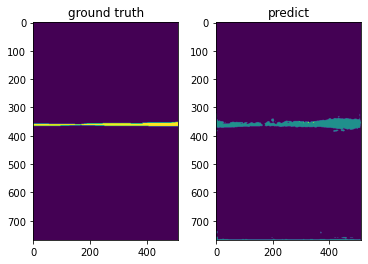

In [240]:
img, mask = test_set[27]
model_predict(best_model_deeplab, img, mask)

accuracy = 0.9906387329101562
iou = 0.49531936782393515


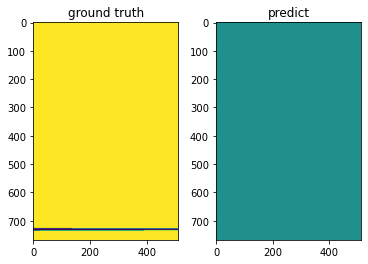

In [241]:
img, mask = test_set[29]
model_predict(best_model_deeplab, img, mask)

accuracy = 0.9736226399739584
iou = 0.487329365711127


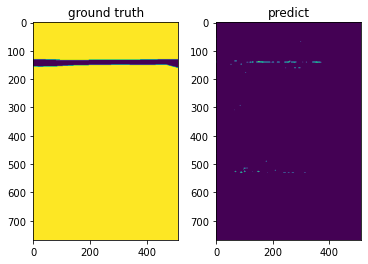

In [248]:
img, mask = test_set[30]
model_predict(best_model_deeplab, img, mask)